In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from openeye import oechem, oedepict, oeomega, oequacpac, oemedchem
from IPython.display import display
import pandas as pd
import oenotebook as oenb
from openmoltools.openeye import get_charges
from openmoltools import openeye
from torsionfit.qmscan.fragment_old import *
import networkx as nx
from torsionfit.qmscan.enumfrags2pdf import main as vis_wrapper

In [2]:
import pandas as pd

In [8]:
fgroups_smarts = {'amide': '[NX3][CX3](=[OX1])[#6]',
                'aldehyde': '[CX3H1](=O)[#6]',
                'alcohol': '[#6][OX2H]',
                 'tri_halide': '[#6][#6]((([F,Cl,I,Br])[F,Cl,I,Br])[F,Cl,I,Br])',
                 'nitrile': '[NX1]#[CX2][#6]',
                 'isonitrile': '[CX1-]#[NX2+]',
                 'ether': '[#6][O][#6]',
                 'alkyne': '[#6][$([CX2]#[CX2])]#[#6]',
                 'tertiary amine': '[NX3]([CX4])([CX4])[CX4]',
                 'sulfide': '[#6][SX2][#6]'}

In [9]:
kinase_inhibitors = pd.read_csv('../../../choderalab/goodiebag/goodiebag/clinical-kinase-inhibitors.csv')

In [10]:
df = kinase_inhibitors[kinase_inhibitors['inhibitor'] == 'Ponatinib']

In [207]:
smiles[4]

'Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(F)(F)F)CN5CCN(CC5)C'

In [11]:
smiles = df['smiles']

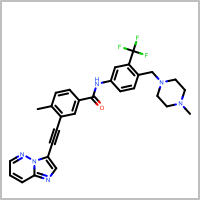

In [12]:
oenb.draw_smiles(smiles.values[0])

In [13]:
mol = openeye.smiles_to_oemol(smiles.values[0])
charged = get_charges(mol, keep_confs=1)

In [14]:
fgroup_tagged = tag_fgroups(charged, fgroups_smarts)

In [15]:
fgroup_tagged

{'alkyne_0': ({6, 7, 8}, {7, 8}),
 'alkyne_1': ({7, 8, 9}, {8, 9}),
 'amide_0': ({4, 18, 19, 20}, {20, 21, 22}),
 'tertiary amine_0': ({31, 32, 33, 37}, {35, 36, 37}),
 'tertiary amine_1': ({34, 35, 36, 38}, {39, 40, 42}),
 'tri_halide_0': ({25, 27, 28, 29, 30}, {30, 31, 32, 33})}

In [20]:
nringsystems, parts = oechem.OEDetermineRingSystems(charged)

In [27]:
for ringidx in range(1, nraromsystems + 1):
    print (ringidx, ". Ring system:", end=" ")
    for atom in charged.GetAtoms():
        if parts[atom.GetIdx()] == ringidx:
            print (atom.GetIdx(), end=" ")
    print ()

1 . Ring system: 1 2 3 4 5 6 
2 . Ring system: 9 10 11 12 13 14 15 16 17 
3 . Ring system: 21 22 23 24 25 26 
4 . Ring system: 32 33 34 35 36 37 


In [69]:
def tag_rings(mol):
    tagged_rings = {}
    nringsystems, parts = oechem.OEDetermineRingSystems(mol)
    for ringidx in range(1, nringsystems +1):
        ringidx_atoms = set()
        for atom in charged.GetAtoms():
            if parts[atom.GetIdx()] == ringidx:
                ringidx_atoms.add(atom.GetIdx())
                tag = oechem.OEGetTag('ringsystem')
                atom.SetData(tag, ringidx)
        # Find bonds in ring and tag
        ringidx_bonds = set()
        for a_idx in ringidx_atoms:
            atom = mol.GetAtom(oechem.OEHasAtomIdx(a_idx))
            for bond in atom.GetBonds():
                nbrAtom = bond.GetNbr(atom)
                nbrIdx = nbrAtom.GetIdx()
                if nbrIdx in ringidx_atoms and nbrIdx != a_idx:
                    ringidx_bonds.add(bond.GetIdx())   
                    tag = oechem.OEGetTag('ringsystem')
                    bond.SetData(tag, ringidx)
        tagged_rings[ringidx] = (ringidx_atoms, ringidx_bonds)
    return tagged_rings
                

In [103]:
tagged_rings = tag_rings(charged)

In [104]:
tagged_rings

{1: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6}),
 2: ({9, 10, 11, 12, 13, 14, 15, 16, 17},
  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}),
 3: ({21, 22, 23, 24, 25, 26}, {24, 25, 26, 27, 28, 29}),
 4: ({32, 33, 34, 35, 36, 37}, {36, 37, 38, 39, 40, 41})}

In [193]:
frags = {}
for bond in charged.GetBonds():
    if bond.IsRotor():
        print(bond)
        atoms = set()
        bonds = set()
        b_idx = bond.GetIdx()
        bonds.add(b_idx)
        beg = bond.GetBgn()
        end = bond.GetEnd()
        beg_idx = beg.GetIdx()
        end_idx = end.GetIdx()
        atoms.add(beg_idx)
        atoms_nb, bonds_nb = iterate_nbratoms(charged, beg, fgroup_tagged, tagged_rings, bond)
        atoms = atoms.union(atoms_nb)
        bonds = bonds.union(bonds_nb)
        atoms.add(end_idx)
        atoms_nb, bonds_nb = iterate_nbratoms(charged, end, fgroup_tagged, tagged_rings, bond)
        atoms = atoms.union(atoms_nb)
        bonds = bonds.union(bonds_nb)
        frags[b_idx] = (atoms, bonds)
        
        
        

20 (4C-18C)
functional_group: False
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: ({18, 19, 20, 4}, {20, 21, 22})
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: ({8, 9, 7}, {8, 9})
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: False
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: ({18, 19, 20, 4}, {20, 21, 22})
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: ({8, 9, 7}, {8, 9})
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: False
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: ({18, 19, 20, 4}, {20, 21, 22})
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: ({8, 9, 7}, {8, 9})
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
22 (18C-20N)
functional_group: False
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6})
functional_group: ({18, 19, 20, 4}, {20, 21, 22})
ring idex: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 

In [170]:
def iterate_nbratoms(mol, atom, fgroup_tagged, tagged_rings, rotor_bond):
    atoms_2 = set()
    bonds_2 = set()
    for a in atom.GetAtoms():
        a_idx = a.GetIdx()
        #if a_idx in atoms_2:
        #    continue
        next_bond = mol.GetBond(a, atom)
        nb_idx = next_bond.GetIdx()
        atoms_2.add(a_idx)
        if nb_idx not in bonds_2:
            bonds_2.add(nb_idx)
        if a.IsInRing():
            ring_idx = a.GetData('ringsystem')
            ratoms, rbonds = tagged_rings[ring_idx]
            atoms_2 = atoms_2.union(ratoms)
            bonds_2 = bonds_2.union(rbonds)
            # Find non-rotatable sustituents
            rs_atoms, rs_bonds = ring_substiuents(mol, next_bond, rotor_bond, tagged_rings, ring_idx, fgroup_tagged)
            atoms_2 = atoms_2.union(rs_atoms)
            bonds_2 = bonds_2.union(rs_bonds)
        fgroup = is_fgroup(fgroup_tagged, atom=atom)
        if fgroup:
            atoms_2 = atoms_2.union(fgroup[0])
            bonds_2 = bonds_2.union(fgroup[-1])
    return atoms_2, bonds_2
        

In [176]:
def ring_substiuents(mol, bond, rotor_bond, tagged_rings, ring_idx, fgroup_tagged):
    rs_atoms = set()
    rs_bonds = set()
    r_atoms, r_bonds = tagged_rings[ring_idx]
    for a_idx in r_atoms:
        atom = mol.GetAtom(oechem.OEHasAtomIdx(a_idx))
        for a in atom.GetAtoms():
            if a.GetIdx() in rs_atoms:
                continue
            fgroup = False
            if not a.IsInRing():
                rs_bond = mol.GetBond(atom, a)
                if not rs_bond.IsRotor():
                    rs_atoms.add(a.GetIdx())
                    #bond = mol.GetBond(atom, a)
                    rs_bonds.add(rs_bond.GetIdx())
                    # Check for functional group
                    fgroup = is_fgroup(fgroup_tagged, atom=a)
                elif is_ortho(rs_bond, rotor_bond, bond):
                    # Keep bond and attached atom.
                    rs_atoms.add(a.GetIdx())
                    rs_bonds.add(rs_bond.GetIdx())
                    # Check for functional group
                    fgroup = is_fgroup(fgroup_tagged, atom=a)
                if fgroup:
                    rs_atoms = rs_atoms.union(fgroup[0])
                    rs_bonds = rs_bonds.union(fgroup[-1])
                print('functional_group: {}'.format(fgroup))
                print('ring idex: {}'.format(tagged_rings[ring_idx]))
                    # Check if ortho
                    #is
                    #if bond.IsInRing():
                        # bond is inside ring so we need to check rotor_bond
                    #    bond = rotor_bond
                    
                    
    return rs_atoms, rs_bonds

In [ ]:
ring_substiuents(charged, frags[])

In [194]:
for frag in frags:
    AtomBondSet = to_AtomBondSet(charged, frags[frag][0], frags[frag][-1])
    frags[frag] = AtomBondSet

In [195]:
frags

{20: <oechem.OEAtomBondSet; proxy of <Swig Object of type 'OEChem::OEAtomBondSet *' at 0x10a48dcf0> >,
 22: <oechem.OEAtomBondSet; proxy of <Swig Object of type 'OEChem::OEAtomBondSet *' at 0x1167b6540> >,
 23: <oechem.OEAtomBondSet; proxy of <Swig Object of type 'OEChem::OEAtomBondSet *' at 0x1167b68d0> >,
 30: <oechem.OEAtomBondSet; proxy of <Swig Object of type 'OEChem::OEAtomBondSet *' at 0x1167b6330> >,
 34: <oechem.OEAtomBondSet; proxy of <Swig Object of type 'OEChem::OEAtomBondSet *' at 0x1166776c0> >,
 35: <oechem.OEAtomBondSet; proxy of <Swig Object of type 'OEChem::OEAtomBondSet *' at 0x1167b6b40> >}

In [196]:
oname = 'test_Ponatinib.pdf'
ToPdf(charged, oname, frags)

0

In [44]:
for bond in mol.GetBonds():
    if bond.IsInRing():
        print(bond)

 1 (1C-6C)
 2 (1C-2C)
 3 (2C-3C)
 4 (3C-4C)
 5 (4C-5C)
 6 (5C-6C)
10 (9C-13N)
11 (9C-10C)
12 (10C-11N)
13 (11N-12C)
14 (12C-17C)
15 (12C-13N)
16 (13N-14N)
17 (14N-15C)
18 (15C-16C)
19 (16C-17C)
24 (21C-26C)
25 (21C-22C)
26 (22C-23C)
27 (23C-24C)
28 (24C-25C)
29 (25C-26C)
36 (32N-37C)
37 (32N-33C)
38 (33C-34C)
39 (34C-35N)
40 (35N-36C)
41 (36C-37C)


In [41]:
for atom in charged.GetAtoms():
    print(atom.GetData())

{}
{'ringsystem': 1}
{'ringsystem': 1}
{'ringsystem': 1}
{'fgroup': 'amide_0', 'ringsystem': 1}
{'ringsystem': 1}
{'fgroup': 'alkyne_0', 'ringsystem': 1}
{'fgroup': 'alkyne_1'}
{'fgroup': 'alkyne_1'}
{'fgroup': 'alkyne_1', 'ringsystem': 2}
{'ringsystem': 2}
{'ringsystem': 2}
{'ringsystem': 2}
{'ringsystem': 2}
{'ringsystem': 2}
{'ringsystem': 2}
{'ringsystem': 2}
{'ringsystem': 2}
{'fgroup': 'amide_0'}
{'fgroup': 'amide_0'}
{'fgroup': 'amide_0'}
{'ringsystem': 3}
{'ringsystem': 3}
{'ringsystem': 3}
{'ringsystem': 3}
{'fgroup': 'tri_halide_0', 'ringsystem': 3}
{'ringsystem': 3}
{'fgroup': 'tri_halide_0'}
{'fgroup': 'tri_halide_0'}
{'fgroup': 'tri_halide_0'}
{'fgroup': 'tri_halide_0'}
{'fgroup': 'tertiary amine_0'}
{'fgroup': 'tertiary amine_0', 'ringsystem': 4}
{'fgroup': 'tertiary amine_0', 'ringsystem': 4}
{'fgroup': 'tertiary amine_1', 'ringsystem': 4}
{'fgroup': 'tertiary amine_1', 'ringsystem': 4}
{'fgroup': 'tertiary amine_1', 'ringsystem': 4}
{'fgroup': 'tertiary amine_0', 'rings

In [147]:
tagged_rings

{1: ({1, 2, 3, 4, 5, 6}, {1, 2, 3, 4, 5, 6}),
 2: ({9, 10, 11, 12, 13, 14, 15, 16, 17},
  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}),
 3: ({21, 22, 23, 24, 25, 26}, {24, 25, 26, 27, 28, 29}),
 4: ({32, 33, 34, 35, 36, 37}, {36, 37, 38, 39, 40, 41})}

In [148]:
fgroup_tagged

{'alkyne_0': ({6, 7, 8}, {7, 8}),
 'alkyne_1': ({7, 8, 9}, {8, 9}),
 'amide_0': ({4, 18, 19, 20}, {20, 21, 22}),
 'tertiary amine_0': ({31, 32, 33, 37}, {35, 36, 37}),
 'tertiary amine_1': ({34, 35, 36, 38}, {39, 40, 42}),
 'tri_halide_0': ({25, 27, 28, 29, 30}, {30, 31, 32, 33})}

In [154]:
if len(tagged_rings[4][0].intersection(fgroup_tagged['tertiary amine_0'][0])) > 1:
    

3

In [182]:
ring_idxs = list(tagged_rings.keys())
fgroups = list(fgroup_tagged.keys())

In [205]:
for idx in ring_idxs:
    for fgroup in fgroups:
        atom_intersection = tagged_rings[idx][0].intersection(fgroup_tagged[fgroup][0])
        if len(atom_intersection) > 1:
            # Must include ring if including fgroup. Add ring atoms and bonds to fgroup
            atoms_union = tagged_rings[idx][0].union(fgroup_tagged[fgroup][0])
            bonds_union = tagged_rings[idx][-1].union(fgroup_tagged[fgroup][-1])
            fgroup_tagged[fgroup] = (atoms_union, bonds_union)
        elif len(atom_intersection) > 0:
            # Check Wiberg bond order of bond
            # First find bond connectiong fgroup and ring
            atom = charged.GetAtom(oechem.OEHasAtomIdx(atom_intersection.pop()))
            for a in atom.GetAtoms():
                if a.GetIdx() in fgroup_tagged[fgroup][0]:
                    bond = charged.GetBond(a, atom)
                    print(bond)
                    print(bond.GetData())

20 (4C-18C)
{'WibergBondOrder': 0.9339971542358398, 'fgroup': 'amide_0', 'fragment idx': 2}
 7 (6C-7C)
{'WibergBondOrder': 1.041509747505188, 'fgroup': 'alkyne_0', 'fragment idx': 1}
 9 (8C-9C)
{'WibergBondOrder': 1.0627270936965942, 'fgroup': 'alkyne_1', 'fragment idx': 1}
30 (25C-27C)
{'WibergBondOrder': 0.9077675938606262, 'fgroup': 'tri_halide_0', 'fragment idx': 5}


In [203]:
atom_intersection.pop()

4

In [185]:
combinations?